In [15]:
!pip install biopython meeko vina py3Dmol pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.8 MB/s  0:00:00m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]


In [6]:
# Step 1: Extract binding affinities from vina output PDBQT
results_file = "Results/4l9k-CC-Site1/4l9k_cc_site1.pdbqt"

affinities = []
with open(results_file) as f:
    for line in f:
        if line.startswith("REMARK VINA RESULT"):
            parts = line.split()
            affinities.append(float(parts[3]))  # kcal/mol

print("Binding affinities (kcal/mol):")
print(affinities)

# Step 2: Save the first docked pose (ligand) as PDB
ligand_out = "docked_pose1.pdb"
with open(results_file) as f_in, open(ligand_out, "w") as f_out:
    write = False
    for line in f_in:
        if line.startswith("MODEL 1"):  # take mode 1 only
            write = True
        elif line.startswith("ENDMDL"):
            write = False
        if write and (line.startswith("HETATM") or line.startswith("ATOM")):
            f_out.write(line)
print(f"Docked ligand pose saved as {ligand_out}")

# Step 3: Visualize protein + docked ligand in 3D
import py3Dmol

viewer = py3Dmol.view(width=400, height=400)
viewer.addModel(open("HSA_Target/4L9K/4l9k.pdbqt").read(), "pdbqt")  # receptor
viewer.setStyle({"cartoon": {"color": "spectrum"}})

viewer.addModel(open(ligand_out).read(), "pdb")  # ligand
viewer.setStyle({"stick": {"colorscheme": "cyanCarbon"}})

viewer.zoomTo()
viewer.show()

Binding affinities (kcal/mol):
[-8.364, -8.076, -7.905, -7.842, -7.471, -7.418, -7.311, -7.087, -7.053]
Docked ligand pose saved as docked_pose1.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
def merge_receptor_ligand(receptor_pdb, vina_out_pdb, merged_pdb):
    """
    Merge receptor PDB (ATOM, HELIX, etc.) with Vina docked ligand (HETATM + CONECT).
    Writes merged file for PLIP.
    """
    with open(receptor_pdb, 'r') as f:
        receptor_lines = [line for line in f if not line.startswith("END")]

    with open(vina_out_pdb, 'r') as f:
        ligand_lines = [line for line in f if line.startswith(("HETATM", "CONECT"))]

    with open(merged_pdb, 'w') as out:
        out.writelines(receptor_lines)
        out.write("\n")
        out.writelines(ligand_lines)
        out.write("END\n")

merge_receptor_ligand("HSA_Target/4L9K/Prep_4l9k.pdb", "Results/4l9k-CC-Site1/4l9k_cc_site1_1.pdb", "Results/4l9k-CC-Site1/complex_4l9k_cc_site1_1.pdb")


In [12]:
!cat HSA_Target/4L9K/Prep_4l9k.pdb Results/4l9k-CC-Site1/4l9k_cc_site1_1.pdb > complex.pdb

In [14]:
!python xmltojson.py Results/4l9k-CC-Site1/report.xml Results/4l9k-CC-Site1/report.json

Wrote Results/4l9k-CC-Site1/report.json with counts: hydrogen_bonds=9, hydrophobic_contacts=5, ionic_interactions=0, water_bridges=0


Wrote counts to plip_counts.csv, total interactions = 14


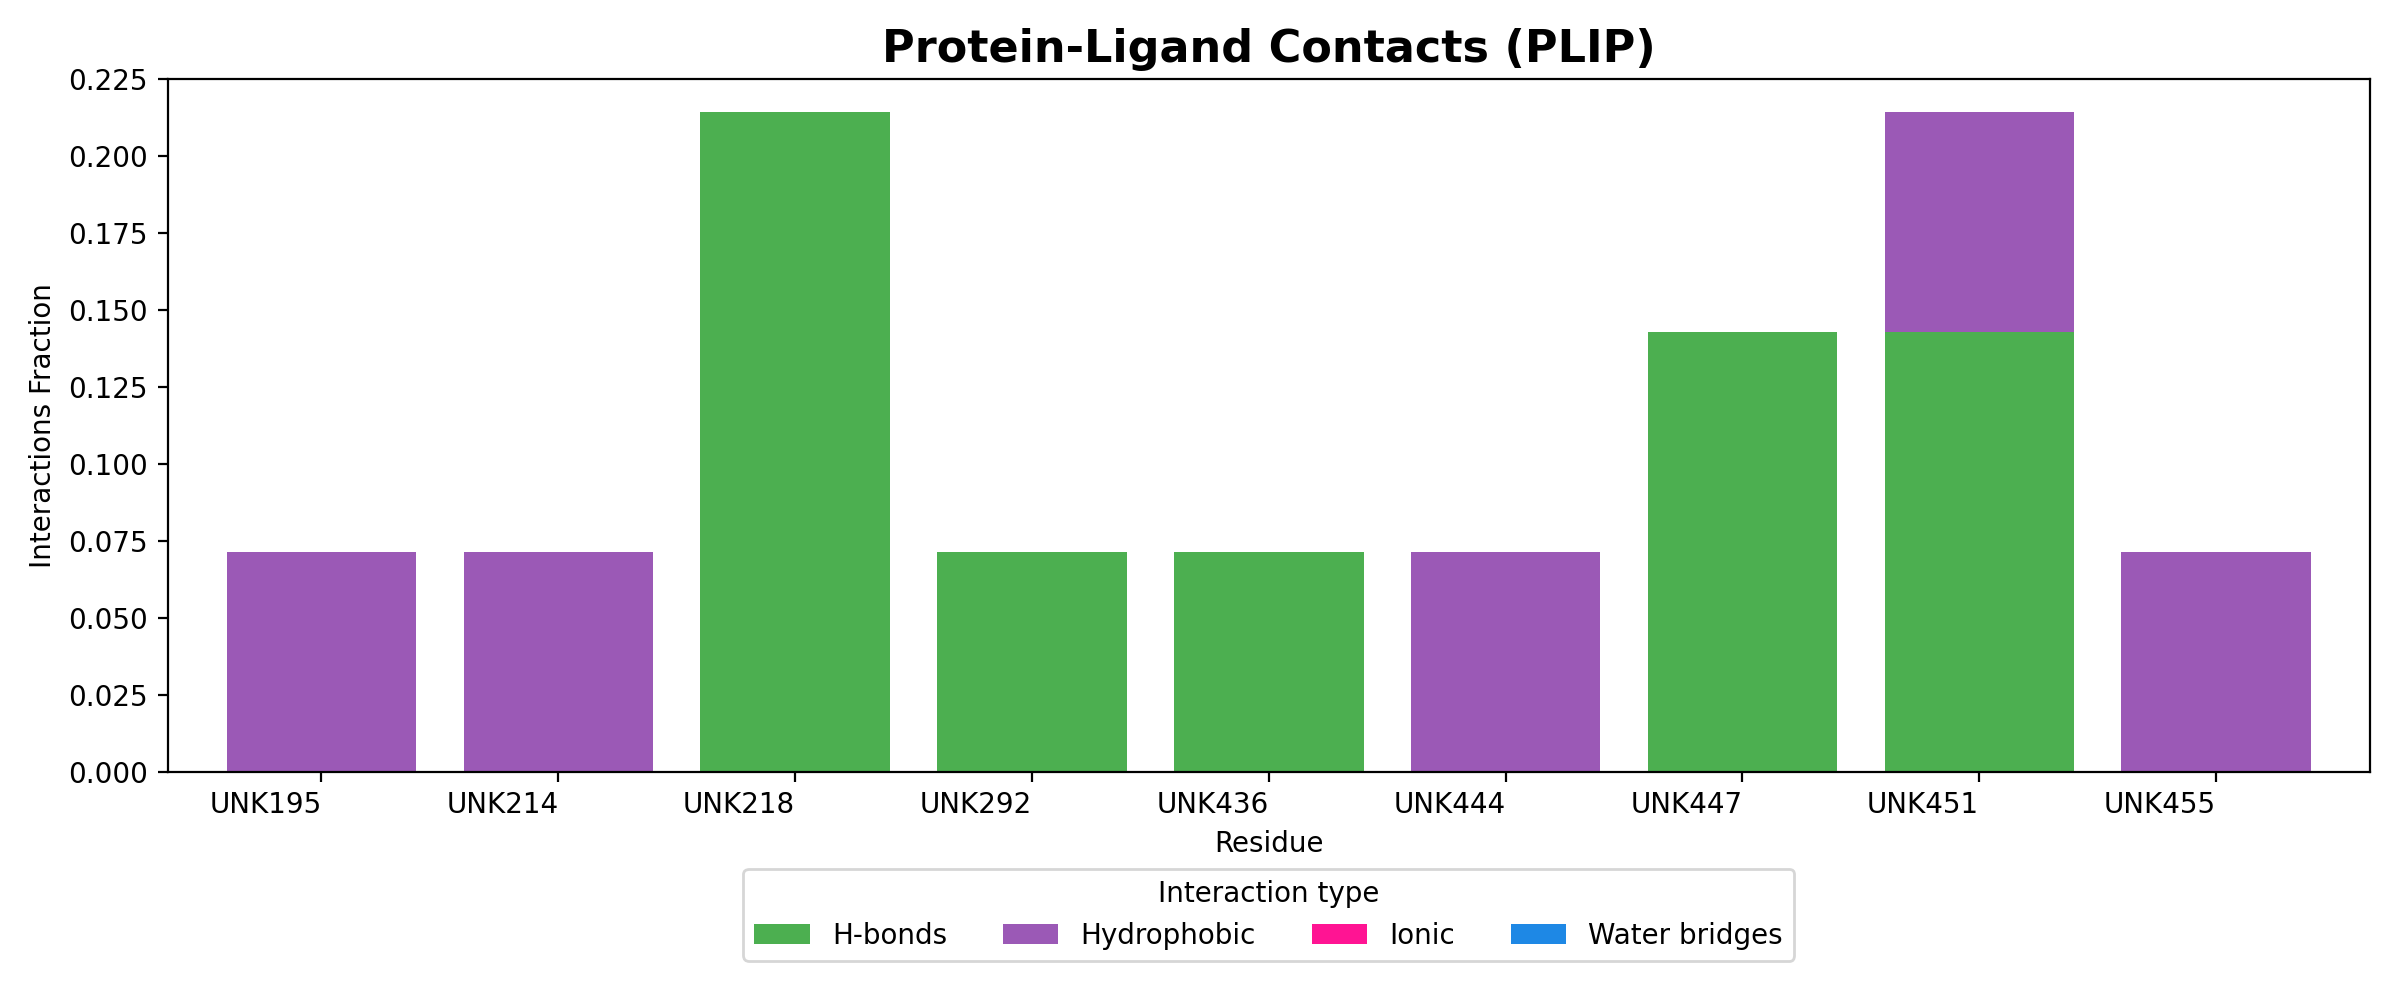

,H-bonds,Hydrophobic,Ionic,Water bridges
UNK195,0,1,0,0
UNK214,0,1,0,0
UNK218,3,0,0,0
UNK292,1,0,0,0
UNK436,1,0,0,0
UNK444,0,1,0,0
UNK447,2,0,0,0
UNK451,2,1,0,0
UNK455,0,1,0,0


In [18]:
# Notebook-friendly: define the functions and run on your JSON file
import json, re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

# --- paste the helper functions from the script ---
def make_res_label(item):
    if not isinstance(item, dict):
        s = str(item)
        m = re.match(r'([A-Z]{2,4})\s*(-?\d+)\s*([A-Za-z]?)', s)
        if m:
            return f"{m.group(1)}{m.group(2)}_{m.group(3)}" if m.group(3) else f"{m.group(1)}{m.group(2)}"
        return s
    name = item.get("resname") or item.get("residue_name") or item.get("residue") or item.get("name")
    num = item.get("resnr") or item.get("residue_number") or item.get("residue_id") or item.get("resSeq") or item.get("number")
    chain = item.get("chain") or item.get("chain_id") or item.get("chainId") or ""
    if name is None and isinstance(item.get("label"), str):
        txt = item.get("label")
        m = re.match(r'([A-Z]{2,4})\s*(-?\d+)\s*([A-Za-z]?)', txt)
        if m:
            name, num, chain = m.group(1), m.group(2), m.group(3) or chain
    name = name or "UNK"
    num = num or "?"
    try:
        num = int(re.search(r"-?\d+", str(num)).group())
    except:
        num = str(num)
    return f"{name}{num}_{chain}" if chain else f"{name}{num}"

def normalize_json(plip_json):
    mapping = {
        'hydrogen': 'H-bonds', 'hbond': 'H-bonds', 'hb': 'H-bonds',
        'hydrophobic': 'Hydrophobic','hydro': 'Hydrophobic','hyd': 'Hydrophobic',
        'ionic': 'Ionic','salt':'Ionic',
        'water': 'Water bridges','bridge':'Water bridges','waters':'Water bridges'
    }
    out = {v: [] for v in set(mapping.values())}
    for k, val in plip_json.items():
        if not isinstance(val, list):
            continue
        lk = k.lower(); chosen = None
        for kw, mapped in mapping.items():
            if kw in lk:
                chosen = mapped; break
        if chosen:
            out[chosen].extend(val); continue
        if val and isinstance(val[0], dict):
            t = (val[0].get('type') or val[0].get('interaction') or "")
            for kw, mapped in mapping.items():
                if isinstance(t, str) and kw in t.lower():
                    chosen = mapped; break
        if chosen:
            out[chosen].extend(val)
        else:
            out['Hydrophobic'].extend(val)
    return out

def build_counts(normalized):
    counts = defaultdict(lambda: {'H-bonds':0, 'Hydrophobic':0, 'Ionic':0, 'Water bridges':0})
    total = 0
    for itype, items in normalized.items():
        for it in items:
            label = make_res_label(it)
            counts[label][itype] += 1
            total += 1
    if not counts:
        return pd.DataFrame(columns=['H-bonds','Hydrophobic','Ionic','Water bridges']), total
    df = pd.DataFrame.from_dict(counts, orient='index').fillna(0).astype(int)
    def sort_key(lbl):
        m = re.search(r"(-?\d+)", lbl)
        return int(m.group(1)) if m else 10**9
    df = df.reindex(sorted(df.index, key=sort_key))
    return df, total

def plot_stacked_fraction(df, total, out_png, title="Protein-Ligand Contacts (PLIP)"):
    frac = df.divide(total) if total>0 else df.astype(float)
    cols = ['H-bonds','Hydrophobic','Ionic','Water bridges']
    frac = frac[cols]
    colors = {'H-bonds':'#4CAF50','Hydrophobic':'#9B59B6','Ionic':'#FF1493','Water bridges':'#1E88E5'}
    color_list = [colors[c] for c in frac.columns]
    fig, ax = plt.subplots(figsize=(12,5))
    frac.plot(kind='bar', stacked=True, ax=ax, color=color_list, width=0.8)
    ax.set_title(title, fontsize=16, fontweight='bold'); ax.set_ylabel("Interactions Fraction"); ax.set_xlabel("Residue")
    ax.legend(title="Interaction type", loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)
    plt.xticks(rotation=0, ha='right'); plt.tight_layout()
    fig.savefig(out_png, dpi=200); plt.close(fig)
    return out_png

# --- specify file paths here ---
json_path = "Results/4l9k-CC-Site1/report.json"        # <-- change to your JSON path
out_png = "plip_plot.png"
out_csv = "plip_counts.csv"

# --- run ---
with open(json_path) as f:
    plip_json = json.load(f)

normalized = normalize_json(plip_json)
df, total = build_counts(normalized)
df.to_csv(out_csv)
print(f"Wrote counts to {out_csv}, total interactions = {total}")
png_file = plot_stacked_fraction(df, total, out_png)
display(Image(png_file, width=900))
display(df.head(50))   # show first 50 rows of the counts